In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import special
from slmsuite.hardware.cameras.alliedvision import AlliedVision

In [2]:
def crop(image, ROI):
    x, width, y, height = ROI
    width = int(width/2)
    height = int(height/2)
    return image[y-height:y+height, x-width:x+width]

In [3]:
AlliedVision.info(verbose=True)
cam = AlliedVision(serial="0441G", verbose=True)

AlliedVision serials:
"0441G"
vimba initializing... success
Looking for cameras... success
vimba sn 0441G initializing... success


## Set Camera Exposure and ROI

Image shape: (3036, 4024)
Exposure time: 8000.0 us
Beam coordinates: (1864, 3080)
Max intensity: 3


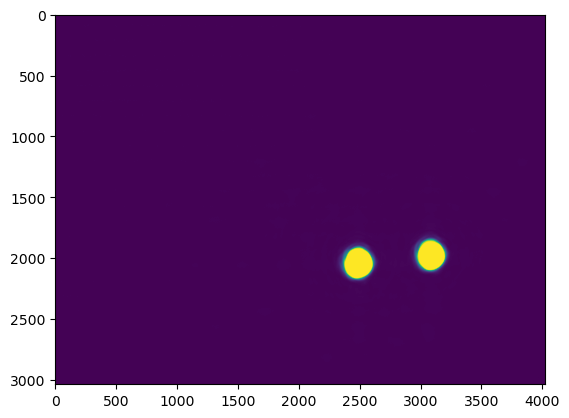

In [4]:
t_exp_s = 8e-3
cam.set_exposure(t_exp_s)

ROI = [1035,100,1443,100]                                           #ROI = [x, width, y, height]

im = cam.get_image()
imc = crop(im, ROI)

plt.imshow(im)

print('Image shape:', cam.default_shape)
print('Exposure time:', np.round(t_exp_s*1e6,0),'us')
print('Beam coordinates:', np.unravel_index(np.argmax(im, axis=None), im.shape))
print('Max intensity:', np.max(imc))

## Z Scan

In [ ]:
ROI = [1035,100,1443,100]            #ROI = [x, width, y, height]
im = cam.get_image()
imc = crop(im,ROI)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(imc)
ax2.plot(imc[50,:])
ax2.grid()

print(np.max(imc))

#np.savetxt(fname='z_scan/-200', X=imc)

In [ ]:
#import data
angles = np.linspace(-200,200,21)
ims = np.zeros((21, 100,100))

for i, angle in enumerate(angles):
    ims[i] = np.loadtxt('z_scan/'+str(int(angle)))

cross_sections = np.zeros((21,100))

for i in range(21):
    cross_sections[i,:] = ims[i,50,:]

z = angles/50*500                           #z displacement in um
r = np.linspace(-50,50,100)*1.84            #radial distance

Z, R = np.meshgrid(r,z)

In [ ]:
plt.pcolormesh(Z, R, cross_sections**0.5)
plt.xlabel('r [um]')
plt.ylabel('z [um]')
plt.xlim((-50,50))
plt.title('Beam profile along optical axis')

In [ ]:
plt.imshow(ims[-1])

## Fitting the Waist

In [ ]:
def Gaussian(x, x0, waist, I0):
    return I0*np.exp(-2*(x-x0)**2/waist**2)

In [ ]:
ns = np.arange(100)

popt, _ = optimize.curve_fit(Gaussian, ns, ims[10,50,:], p0=[50,5,250])

plt.plot(ims[10,50,:])
plt.plot(Gaussian(ns,popt[0],popt[1],popt[2]))
plt.grid()

print('waist focus:', popt[1]*1.84, 'um')
print('waist large beam:', 0.56*250/(np.pi*popt[1]*1.84), 'mm')

## Knife Edge Waist Measurement

In [ ]:
im = cam.get_image()
imc = crop(im, [1811,3000,1980,2000])
plt.imshow(imc)

print(np.sum(imc))
print(np.max(imc))

print('Image shape:', cam.default_shape)
print('Exposure time:', np.round(t_exp_s*1e6,0),'us')
print('Beam coordinates:', np.unravel_index(np.argmax(im, axis=None), im.shape))

In [ ]:
def error_func(x, x0, waist, a, offset):
    return a*special.erf(np.sqrt(2)*(x-x0)/waist)+offset

#Note: scipy erf = integral of e^(-t^2) dt
#Power measured in knife edge measurement: P ~ integral e^(-2*x^2/w^2) dx
#Thus, the substitution t = \sqrt(2)*x/w

In [ ]:
P = np.array([31,149,253, 396, 596, 809, 1087, 1425, 1763, 2051, 2586, 2986, 3412, 3817, 4375, 4784, 5162, 5651, 5928, 6212, 6618, 6768, 6801, 6992, 7151, 7349])           #25 cm away from telescope
P2 = np.array([7249, 7080, 6944, 6826,6612,6363, 6093, 5860, 5666, 5252, 4764, 4452, 4006, 3667, 3141, 2683, 2257, 1875, 1530, 1218, 869, 658, 473, 283, 168, 67, 5, 1])    #2 cm away from telescope

P = P/np.max(P)
P2 = P2/np.max(P2)

P2 = P2[::-1]
x = np.arange(len(P))*0.5  #in mm
x2 = np.arange(len(P2))*0.5  #in mm

popt, pcov = optimize.curve_fit(error_func, x, P, [6, 5, 0.5, 0.5])
popt2, pcov2 = optimize.curve_fit(error_func, x2, P2, [6, 5, 0.5, 0.5])

plt.plot(x, P, 'o', label='25 cm')
plt.plot(x2, P2, 'o', label='2 cm')
plt.plot(x, error_func(x, popt[0], popt[1], popt[2], popt[3]), 'k-.')
plt.plot(x2, error_func(x2, popt2[0], popt2[1], popt2[2], popt2[3]), 'k-.', label = 'fits')

plt.grid()
plt.xlabel('Knife Edge Position [mm]')
plt.ylabel('Power [a.u.]')
plt.title('Knife Edge Waist Measurement')
plt.legend()

print('Beam waists')
print('z = 2 cm:', np.round(popt2[1],2),'mm')
print('z = 25 cm:', np.round(popt[1],2),'mm')

In [ ]:
np.pi*1.5**2/0.56

Checking collimation

In [ ]:
t_exp_s = 3e-3
cam.set_exposure(t_exp_s)

ROI = [1285,1200,1343,1200]            #ROI = [x, width, y, height]

im = cam.get_image()
imc = crop(im, ROI)

plt.imshow(imc)
print(np.max(imc))

print(np.sum(imc))

In [ ]:
t_exp_s = 15e-3
cam.set_exposure(t_exp_s)

im = cam.get_image()
imc = crop(im, [1811,3000,1980,2000])
plt.imshow(imc)

print(np.sum(imc))
print(np.max(imc))

print('Image shape:', cam.default_shape)
print('Exposure time:', np.round(t_exp_s*1e6,0),'us')
print('Beam coordinates:', np.unravel_index(np.argmax(im, axis=None), im.shape))

In [ ]:
P = np.array([66169096, 66406917, 65180050, 64076045, 59604016, 52951160, 43896165, 34765920])           #far away from telescope
P2 = np.array([67203266, 68088715, 67707715, 65419171, 62571271, 57417829, 48493674, 39101560])    #near telescope

P = P/np.max(P)
P2 = P2/np.max(P2)


x = np.arange(len(P))*2  #in mm
x2 = np.arange(len(P2))*2  #in mm

popt, pcov = optimize.curve_fit(f=error_func, xdata=x, ydata=P, p0=[6, 5, 0.5, 0.5])
popt2, pcov2 = optimize.curve_fit(error_func, x2, P2, [6, 5, 0.5, 0.5])

plt.plot(x, P, 'o', label='far')
plt.plot(x2, P2, 'o', label='near')
plt.plot(x, error_func(x, popt[0], popt[1], popt[2], popt[3]), 'k-.')
plt.plot(x2, error_func(x2, popt2[0], popt2[1], popt2[2], popt2[3]), 'k-.', label = 'fits')

plt.grid()
plt.xlabel('Knife Edge Position [mm]')
plt.ylabel('Power [a.u.]')
plt.title('Knife Edge Waist Measurement')
plt.legend()

print('Beam waists')
print('z = near cm:', np.round(popt2[1],2),'mm')
print('z = far cm:', np.round(popt[1],2),'mm')
print(np.sqrt(np.diag(pcov))[1])
print(np.sqrt(np.diag(pcov2))[1])

In [ ]:
t_exp_s = 15e-3
cam.set_exposure(t_exp_s)

im = cam.get_image()
imc = crop(im, [1811,3000,1980,2000])
plt.imshow(imc)

print(np.sum(imc))
print(np.max(imc))

print('Image shape:', cam.default_shape)
print('Exposure time:', np.round(t_exp_s*1e6,0),'us')
print('Beam coordinates:', np.unravel_index(np.argmax(im, axis=None), im.shape))

In [ ]:
P = np.array([1, 2, 3, 4])           #far away from telescope
P2 = np.array([69059206, 68547404, 68440602, 65977743, 63551323, 57604641, 48486861, 38383421])    #near telescope

P = P/np.max(P)
P2 = P2/np.max(P2)


x = np.arange(len(P))*2  #in mm
x2 = np.arange(len(P2))*2  #in mm

popt, pcov = optimize.curve_fit(f=error_func, xdata=x, ydata=P, p0=[6, 5, 0.5, 0.5])
popt2, pcov2 = optimize.curve_fit(error_func, x2, P2, [6, 5, 0.5, 0.5])

plt.plot(x, P, 'o', label='far')
plt.plot(x2, P2, 'o', label='near')
plt.plot(x, error_func(x, popt[0], popt[1], popt[2], popt[3]), 'k-.')
plt.plot(x2, error_func(x2, popt2[0], popt2[1], popt2[2], popt2[3]), 'k-.', label = 'fits')

plt.grid()
plt.xlabel('Knife Edge Position [mm]')
plt.ylabel('Power [a.u.]')
plt.title('Knife Edge Waist Measurement')
plt.legend()

print('Beam waists')
print('z = near cm:', np.round(popt2[1],2),'mm')
print('z = far cm:', np.round(popt[1],2),'mm')
print(np.sqrt(np.diag(pcov))[1])
print(np.sqrt(np.diag(pcov2))[1])

Collimated beam imaging

In [ ]:
t_exp_s = 13e-3
cam.set_exposure(t_exp_s)

im = cam.get_image()
imc = crop(im, [2300, 50,1277,50])
plt.imshow(imc)

print(np.sum(imc))
print(np.max(imc))

print('Image shape:', cam.default_shape)
print('Exposure time:', np.round(t_exp_s*1e6,0),'us')
print('Beam coordinates:', np.unravel_index(np.argmax(im, axis=None), im.shape))

np.savetxt(fname='coll', X=imc)

In [ ]:
ims1 = np.loadtxt('coll')

print(ims1[25])

In [ ]:
def Gaussian(x, x0, waist, I0):
    return I0*np.exp(-2*(x-x0)**2/waist**2)

In [ ]:
ns = np.arange(50)

popt, _ = optimize.curve_fit(Gaussian, ns, ims1[25], p0=[50,5,250])

plt.plot(ims1[25])
plt.plot(Gaussian(ns,popt[0],popt[1],popt[2]))
plt.grid()

print('waist focus:', popt[1]*1.84, 'um')
print('waist large beam:', 0.56*250/(np.pi*popt[1]*1.84), 'mm')

In [ ]:
t_exp_s = 13e-3
cam.set_exposure(t_exp_s)

im = cam.get_image()
imc = crop(im, [2300,101,1277,101])
plt.imshow(imc)

print(np.sum(imc))
print(np.max(imc))

print('Image shape:', cam.default_shape)
print('Exposure time:', np.round(t_exp_s*1e6,0),'us')
print('Beam coordinates:', np.unravel_index(np.argmax(im, axis=None), im.shape))

np.savetxt(fname='coll2', X=imc)

In [ ]:
ims = np.loadtxt('coll2')

print(ims[50])

In [ ]:
def Gaussian(x, x0, waist, I0):
    return I0*np.exp(-2*(x-x0)**2/waist**2)

In [ ]:
ns = np.arange(100)

popt, _ = optimize.curve_fit(Gaussian, ns, ims[50], p0=[50,7,250])

plt.plot(ims[50])
plt.plot(Gaussian(ns,popt[0],popt[1],popt[2]))
plt.grid()

print('waist focus:', popt[1]*1.84, 'um')
print('waist large beam:', 0.56*250/(np.pi*popt[1]*1.84), 'mm')
print(popt)

In [ ]:
plt.plot(ims[50])

In [ ]:
t_exp_s = 1.2e-3
cam.set_exposure(t_exp_s)

im = cam.get_image()
imc = crop(im, [2080,20,1842,20])
plt.imshow(imc)

print(np.sum(imc))
print(np.max(imc))

print('Image shape:', cam.default_shape)
print('Exposure time:', np.round(t_exp_s*1e6,0),'us')
print('Beam coordinates:', np.unravel_index(np.argmax(im, axis=None), im.shape))

In [ ]:
np.savetxt(fname='holey 2', X=imc)

In [ ]:
def Gaussian(x, x0, waist, I0):
    return I0*np.exp(-2*(x-x0)**2/waist**2)

In [ ]:
ns = np.arange(20)

popt, _ = optimize.curve_fit(Gaussian, ns, imc[11], p0=[10,1,208])
x0=11
waist=1.2
I0=211
plt.plot(imc[11], label="raw data")
plt.plot(Gaussian(ns,popt[0],popt[1],popt[2]), label="curve fit")
plt.legend()
plt.grid()

print('waist focus:', popt[1], 'pixels')
print('waist' ,popt[1]*1.84, 'um')

In [ ]:

plt.plot(imc[11], label="raw data")

plt.plot(ns, I0*np.exp(-2*(ns-x0)**2/waist**2), label="my fit")